### Evaluation of Variational Autoencoder (VAE) for KDD CUP

## The Method

1. Prepare data & Partition the data into 80-20 train-test split
2. Define Models & Parameters
3. Perform Cross-Validation on the training data
3. (Re)Train the models on the training data, either vanilla model or with best hyperparameters
4. Evaluate the (re)trained models on the test data
5. Final evaluation of the models

![The Method](method.png)

Source: [scikit-learn.org - Cross-validation](https://scikit-learn.org/1.5/modules/cross_validation.html#cross-validation-and-model-selection)

In [3]:
# Import libraries
import pandas as pd
import numpy as np
from pandas import DataFrame as df
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imblearn_pipeline

from sklearn.metrics import make_scorer, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from pyod.models.vae import VAE

from pprint import pprint
from time import time

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
CROSS_VAL_SPLITS = 5
CKP_PREFIX = 'KDD_'

np.random.seed(RANDOM_STATE)

# pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


### 1. Prepare data & Partition the data into 80-20 train-test split

Label Mapping: {'attack': 0, 'normal': 1}
Normal Label: 1
Attack Label: 0


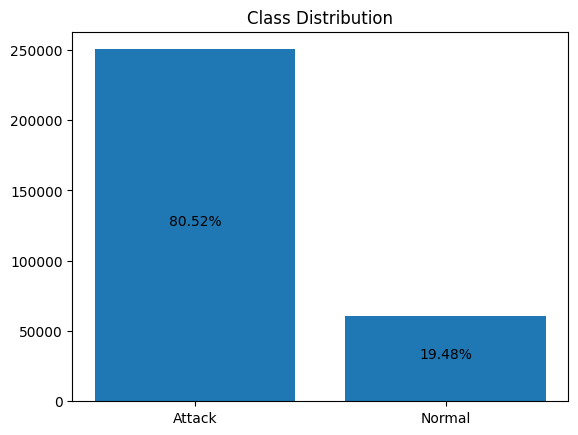

In [4]:
# Importing the dataset
path_to_data = '../data/kddcup/kddcup_data_corrected.csv'

# col names from https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
col_names = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
    "label",
]
# from https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
categorical_cols = [
    "protocol_type",
    "service",
    "flag",
    "land",
    "logged_in",
    "is_host_login",
    "is_guest_login",
]

# Read data (10 % subset of the original dataset)
data = pd.read_csv(path_to_data, names=col_names, header=None)

# Label encoding
data["label"] = data["label"].apply(lambda x: "attack" if x != "normal." else 'normal')
le = LabelEncoder()
y = le.fit_transform(data["label"])
X = data.drop("label", axis=1)

# Extract label mapping
label_mapping = {label: index for index, label in enumerate(le.classes_)}
normal_label = label_mapping['normal']
attack_label = label_mapping['attack']
print("Label Mapping:", label_mapping)
print("Normal Label:", normal_label)
print("Attack Label:", attack_label)

# Visualize class imbalance
plt.bar(["Attack", "Normal"], data["label"].value_counts())
total = len(data)
fraud_percentage = (data["label"].value_counts()[1] / total) * 100
normal_percentage = (data["label"].value_counts()[0] / total) * 100

plt.text(0, data["label"].value_counts()[0] / 2, f'{normal_percentage:.2f}%', ha='center', color='black')
plt.text(1, data["label"].value_counts()[1] / 2, f'{fraud_percentage:.2f}%', ha='center', color='black')
plt.title("Class Distribution")
plt.show()

# create training and test partitions with 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Fit OneHotEncoder to learn categories from the training data. This is necessary to ensure that the same categories are used for random splits during cross-validation
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype="int8")
one_hot_encoder.fit(X_train[categorical_cols])
learned_categories = one_hot_encoder.categories_

# Define numerical columns & indices
num_cols = data.drop(categorical_cols, axis=1)
num_indices = [data.columns.get_loc(col) for col in num_cols.drop('label', axis=1).columns]
cat_indices = [data.columns.get_loc(col) for col in categorical_cols]

# Define preprocessing transformers and pipeline

# Numerical transformer. Scales numerical data using StandardScaler
numeric_transformer = imblearn_pipeline(
    steps=[("scaler", StandardScaler())], verbose=True
)

# Categorical transformer. Encodes categorical data using OneHotEncoder
categorical_transformer = imblearn_pipeline(
    steps=[
        (
            "onehot",
            OneHotEncoder(
                handle_unknown="ignore",
                sparse_output=False,
                categories=learned_categories,
                dtype="int8",
            ),
        )
    ],
    verbose=True,
)

# Define preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_indices),
        ("cat", categorical_transformer, cat_indices),
    ],
    verbose=True,
)


### 2. Define models and parameters

In [5]:
vae_estimator = VAE(
	encoder_neuron_list=[128, 128,64],
	decoder_neuron_list=[64,128,128],
	lr=1e-6,
	beta=0.5,
	epoch_num=5,
	batch_size=128,
	optimizer_name='adam',
	latent_dim=80,
	preprocessing=False, # Apply preprocessing to input data
	verbose=1,
	hidden_activation_name='relu',
	random_state=RANDOM_STATE,
)

# Define pipeline with preprocessor and VAE model
pipeline = Pipeline(
	steps=[
		("preprocessor", preprocessor),
		("vae", vae_estimator),
	]
)

### 3. Perform Cross-Validation on the training data

In [2]:
# Initialize lists to store metrics for each CV run
precision_scores = []
recall_scores = []
f1_scores = []

# fit preprocessors on the full training data
preprocessor.fit(X_train)

for i, (train_idx, test_idx) in enumerate(StratifiedKFold(n_splits=5).split(X_train, y_train)):
    print("\n")
    print("-" * 50)
    print(f"[CV {i+1} ...]")

    y_train_train_normal = y_train.iloc[train_idx] if isinstance(y_train, pd.DataFrame) else y_train[train_idx]
    y_train_test_normal = y_train.iloc[test_idx] if isinstance(y_train, pd.DataFrame) else y_train[test_idx]

    print(f"Train normal samples: {len(y_train_train_normal[y_train_train_normal == normal_label])}")
    print(f"Test normal samples: {len(y_train_test_normal[y_train_test_normal == normal_label])}")
    
    X_train_split = X_train.iloc[train_idx].copy()
    X_test_split = X_train.iloc[test_idx].copy()

    y_train_split = y_train[train_idx]
    y_test_split = y_train[test_idx]

    # Transform the filtered data without re-fitting
    transformed_sample = preprocessor.transform(X_train_split[y_train_split == attack_label])

    # debugging 
    print("transformed_sample shape: ", transformed_sample.shape)

    # Proceed to fit your model
    if np.isnan(transformed_sample).any():
        print("NaNs detected in the transformed data. Investigating...")
        nan_indices = np.where(np.isnan(transformed_sample))
        print("NaN indices:", nan_indices)
    vae_estimator.fit(transformed_sample)

    # predict
    y_pred = vae_estimator.predict(preprocessor.transform(X_test_split))

    # Evaluate the model
    f1 = f1_score(y_test_split, y_pred, average='binary') # weighted: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label).
    recall = recall_score(y_test_split, y_pred, average='binary')
    precision = precision_score(y_test_split, y_pred, average='binary')

    # Append metrics to lists
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Print average metrics
print("\n")
print("-" * 50)
print("Average Metrics")
print(f"Recall: {np.mean(recall_scores):.2f}")
print(f"Precision: {np.mean(precision_scores):.2f}")
print(f"F1: {np.mean(f1_scores):.2f}")
print("-" * 50)

NameError: name 'preprocessor' is not defined

In [9]:
# fit preprocessors on the full training data
transformed_sample = preprocessor.fit_transform(X_train)

df(transformed_sample).head()

[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.1s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120
0,-0.04417,-0.012447,-0.043774,-0.019011,-0.005212,-0.045244,-0.046814,-0.007988,-0.01389,-0.003472,-0.003534,-0.004291,-0.005912,-0.025861,0.0,-1.212037,-0.972870,-0.25361,-0.252527,-0.410024,-0.408193,0.49604,-0.228287,-0.202214,0.324064,0.556318,0.533425,-0.25945,-1.094600,-0.129223,-0.254468,-0.252775,-0.413872,-0.408506,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,-0.04417,-0.011282,0.103278,-0.019011,-0.005212,-0.045244,-0.046814,-0.007988,-0.01389,-0.003472,-0.003534,-0.004291,-0.005912,-0.025861,0.0,-1.207489,-0.922731,-0.25361,-0.252527,-0.410024,-0.408193,0.49604,-0.228287,0.833119,-3.794077,0.556318,0.533425,-0.25945,-0.606716,1.297347,-0.254468,-0.252775,-0.413872,-0.408506,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,-0.04417,-0.005523,-0.043774,-0.019011,-0.005212,-0.045244,-0.046814,-0.007988,-0.01389,-0.003472,-0.003534,-0.004291,-0.005912,-0.025861,0.0,1.098651,1.149678,-0.25361,-0.252527,-0.410024,-0.408193,0.49604,-0.228287,-0.202214,0.324064,0.556318,0.533425,-0.25945,0.917922,-0.129223,-0.254468,-0.252775,-0.413872,-0.408506,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,-0.04417,-0.005523,-0.043774,-0.019011,-0.005212,-0.045244,-0.046814,-0.007988,-0.01389,-0.003472,-0.003534,-0.004291,-0.005912,-0.025861,0.0,1.098651,1.149678,-0.25361,-0.252527,-0.410024,-0.408193,0.49604,-0.228287,-0.202214,0.324064,0.556318,0.533425,-0.25945,0.917922,-0.129223,-0.254468,-0.252775,-0.413872,-0.408506,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,-0.04417,-0.009119,-0.043774,-0.019011,-0.005212,-0.045244,-0.046814,-0.007988,-0.01389,-0.003472,-0.003534,-0.004291,-0.005912,-0.025861,0.0,1.098651,1.149678,-0.25361,-0.252527,-0.410024,-0.408193,0.49604,-0.228287,-0.202214,0.324064,0.556318,0.533425,-0.25945,0.917922,-0.129223,-0.254468,-0.252775,-0.413872,-0.408506,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [11]:
from pyod.models.vae import VAE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

# Initialize cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = []
precision_scores = []
recall_scores = []

# for train_index, val_index in kf.split(X_train, y_train):
for (i, (train_index, val_index)) in enumerate(kf.split(X_train, y_train)):
    print(f"Fold {i+1}/{CROSS_VAL_SPLITS}")
    X_train_fold = X_train.iloc[train_index].copy()
    X_val_fold = X_train.iloc[val_index].copy()
    y_val_fold = y_train[val_index].copy()

    print("Fitting preprocessor...")
    # Fit preprocessor
    preprocessor.fit(X_train_fold)

    # transform data
    print("Transforming data...")
    X_train_fold = preprocessor.transform(X_train_fold)
    X_val_fold = preprocessor.transform(X_val_fold)
    print("Data transformed.")

    print("Fitting VAE model...")
    # Initialize and train VAE model
    clf = VAE(epoch_num=30, batch_size=32, dropout_rate=0.2)
    # clf = VAE(
    #     encoder_neuron_list=[128, 128,64],
    #     decoder_neuron_list=[64,128,128],
    #     lr=1e-6,
    #     beta=0.5,
    #     epoch_num=15,
    #     batch_size=128,
    #     optimizer_name='adam',
    #     latent_dim=80,
    #     preprocessing=False, # Apply preprocessing to input data
    #     verbose=1,
    #     hidden_activation_name='relu',
    #     random_state=RANDOM_STATE,
    # )
    clf.fit(X_train_fold)
    print("VAE model fitted.")
    
    print("Predicting on validation set...")
    # Predict on validation set
    y_val_scores = clf.decision_function(X_val_fold)  # Outlier scores
    y_val_pred = clf.predict(X_val_fold)  # Predicted labels (0: inlier, 1: outlier)
    print("Predictions made.")

    print('Calculating metrics...')
    # Calculate metrics
    f1 = f1_score(y_val_fold, y_val_pred)
    precision = precision_score(y_val_fold, y_val_pred)
    recall = recall_score(y_val_fold, y_val_pred)
    
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Report mean and standard deviation of metrics
print("Cross-Validation Results:")
print(f"F1-Score: Mean={np.mean(f1_scores):.4f}, Std={np.std(f1_scores):.4f}")
print(f"Precision: Mean={np.mean(precision_scores):.4f}, Std={np.std(precision_scores):.4f}")
print(f"Recall: Mean={np.mean(recall_scores):.4f}, Std={np.std(recall_scores):.4f}")

Fold 1/5
Fitting preprocessor...
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.1s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s
Transforming data...
Data transformed.
Fitting VAE model...


Training: 100%|██████████| 30/30 [04:54<00:00,  9.82s/it]


VAE model fitted.
Predicting on validation set...
Predictions made.
Calculating metrics...
Fold 2/5
Fitting preprocessor...
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.1s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.1s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.1s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s
Transforming data...
Data transformed.
Fitting VAE model...


Training: 100%|██████████| 30/30 [05:02<00:00, 10.09s/it]


VAE model fitted.
Predicting on validation set...
Predictions made.
Calculating metrics...
Fold 3/5
Fitting preprocessor...
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.1s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.1s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.1s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s
Transforming data...
Data transformed.
Fitting VAE model...


Training: 100%|██████████| 30/30 [05:29<00:00, 10.98s/it]


VAE model fitted.
Predicting on validation set...
Predictions made.
Calculating metrics...
Fold 4/5
Fitting preprocessor...
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.1s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s
Transforming data...
Data transformed.
Fitting VAE model...


Training: 100%|██████████| 30/30 [05:27<00:00, 10.93s/it]


VAE model fitted.
Predicting on validation set...
Predictions made.
Calculating metrics...
Fold 5/5
Fitting preprocessor...
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.1s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s
Transforming data...
Data transformed.
Fitting VAE model...


Training: 100%|██████████| 30/30 [05:01<00:00, 10.05s/it]


VAE model fitted.
Predicting on validation set...
Predictions made.
Calculating metrics...
Cross-Validation Results:
F1-Score: Mean=0.1698, Std=0.0051
Precision: Mean=0.2500, Std=0.0071
Recall: Mean=0.1286, Std=0.0041


### 4. (Re)Train the models on the training data, either vanilla model or with best hyperparameters

In [17]:
# Fit the preprocessor on the full training data
preprocessor.fit(X_train)

# Transform the filtered data without re-fitting
transformed_sample = preprocessor.transform(X_train)

# Check for NaNs
if np.isnan(transformed_sample).any():
    print("NaNs detected in the transformed data.")
else:
    print("No NaNs in the transformed data.")


# Proceed to fit your model
clf = VAE(epoch_num=30, batch_size=32, dropout_rate=0.2)
clf.fit(transformed_sample) # 6min 33s training time


[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.1s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s
No NaNs in the transformed data.


Training: 100%|██████████| 30/30 [06:30<00:00, 13.01s/it]


### 5. Final evaluation of the models

Recall: 0.13
Precision: 0.24
F1: 0.17


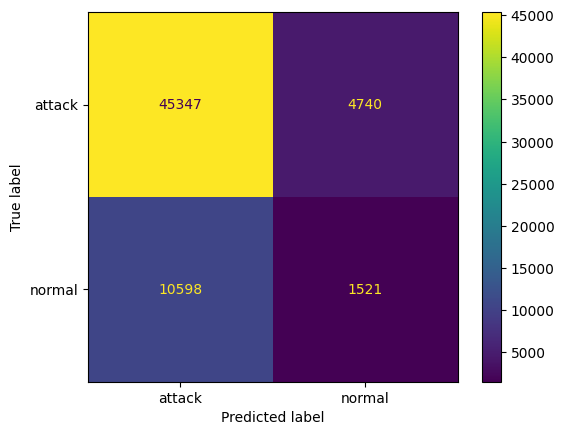

In [18]:
# predict
y_pred = clf.predict(preprocessor.transform(X_test))

# Evaluate the model
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1: {f1:.2f}")

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()